<a href="https://colab.research.google.com/github/shivammehta007/Social-Network-Analysis/blob/master/Demographic_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Opening Data

In [0]:
data_path = os.path.join('drive', 'My Drive', 'Colab Notebooks', 'SNA Lab', 'SNA-Lab3')
file_london = pd.read_csv(os.path.join(data_path, 'LondonTrain.csv'))
file_newyork = pd.read_csv(os.path.join(data_path, 'NYTrain.csv'))
file_singapore = pd.read_csv(os.path.join(data_path, 'SingaporeTrain.csv'))

## EDA: Exploratory Data Analysis

### Heads

In [0]:
# Dropping Row ID
file_london.drop(['row ID'], axis=1, inplace=True)
file_newyork.drop(['row ID'], axis=1, inplace=True)
file_singapore.drop(['row ID'], axis=1, inplace=True)

In [5]:
file_london.head()

,educationInfoForAgeGroupEstimation,workInfoForAgeGroupEstimation,gender,realAge,ageGroup,relationship,educationLevel,occupation,income
0,NaN,NaN,female,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Edenred Employee Benefits Advisor � November 2...,female,NaN,NaN,NaN,NaN,personal care and service,NaN
2,"Uppsala University Egyptology � Uppsala, Sweden",NaN,male,NaN,NaN,NaN,undergraduate,NaN,NaN
3,NaN,"Booking.com Cambridge, Cambridgeshire",male,NaN,NaN,NaN,NaN,NaN,NaN
4,University of Verona 2008 to 2010 � Nursing � ...,Coogee Pavilion Pizza Chef � 13 April 2015 to ...,male,NaN,NaN,single,undergraduate,food preparation and service related,NaN


In [6]:
file_newyork.head()

,educationInfoForAgeGroupEstimation,workInfoForAgeGroupEstimation,gender,realAge,ageGroup,relationship,educationLevel,occupation,income
0,Universidad Santo Tom�s Class of 2009 � Psycho...,GMO Chile Analista de Selecci�n y Desarrollo �...,female,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,male,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,male,NaN,NaN,in a relationship,NaN,NaN,NaN
3,NaN,Commonwealth of Massachusetts Legislative Aide...,male,NaN,NaN,NaN,NaN,healthcare support,NaN
4,NaN,Mindshare Pan Regional Director � 1 October 20...,female,NaN,NaN,NaN,NaN,management,NaN


In [7]:
file_singapore.head()

,educationInfoForAgeGroupEstimation,workInfoForAgeGroupEstimation,gender,realAge,ageGroup,relationship,educationLevel,occupation,income
0,NaN,NaN,female,NaN,NaN,NaN,NaN,NaN,NaN
1,Bukit Batok Secondary School ITE College West ...,NaN,female,NaN,NaN,NaN,college,NaN,NaN
2,"St Patrick&#039;s School, Singapore Class of 2...",NaN,male,NaN,AGE10_20,single,college,NaN,NaN
3,NaN,NaN,female,NaN,NaN,NaN,NaN,NaN,$$
4,NaN,PT. Duta Marga Lestarindo September 2013 to pr...,female,NaN,NaN,NaN,NaN,archetecture and engineering,NaN


In [8]:
file_singapore.isnull().sum(axis=0) 

educationInfoForAgeGroupEstimation    2498
workInfoForAgeGroupEstimation         3063
gender                                  11
realAge                               4500
ageGroup                              3640
relationship                          3584
educationLevel                        3073
occupation                            3856
income                                4320
dtype: int64

In [9]:
column_names = file_singapore.columns
for i in column_names:
    print('{} Value Length : {}'.format(i, len(file_newyork[i].unique())))

educationInfoForAgeGroupEstimation Value Length : 674
workInfoForAgeGroupEstimation Value Length : 947
gender Value Length : 3
realAge Value Length : 1
ageGroup Value Length : 1
relationship Value Length : 4
educationLevel Value Length : 5
occupation Value Length : 22
income Value Length : 5


In [0]:
# Add city column in each and merge them
file_london['city'] = 'London'
file_newyork['city'] = 'New York'
file_singapore['city'] = 'Singapore'

train_data = pd.concat([file_london, file_newyork, file_singapore])

In [20]:
train_data.head()

,educationInfoForAgeGroupEstimation,workInfoForAgeGroupEstimation,gender,realAge,ageGroup,relationship,educationLevel,occupation,income,city
0,NaN,NaN,female,NaN,NaN,NaN,NaN,NaN,NaN,London
1,NaN,Edenred Employee Benefits Advisor � November 2...,female,NaN,NaN,NaN,NaN,personal care and service,NaN,London
2,"Uppsala University Egyptology � Uppsala, Sweden",NaN,male,NaN,NaN,NaN,undergraduate,NaN,NaN,London
3,NaN,"Booking.com Cambridge, Cambridgeshire",male,NaN,NaN,NaN,NaN,NaN,NaN,London
4,University of Verona 2008 to 2010 � Nursing � ...,Coogee Pavilion Pizza Chef � 13 April 2015 to ...,male,NaN,NaN,single,undergraduate,food preparation and service related,NaN,London


### EDA

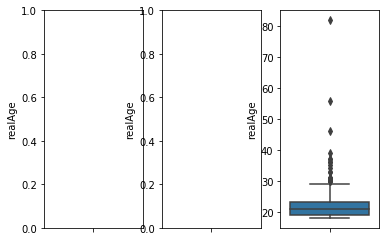

In [10]:
# Age Analysis
fig, axis = plt.subplots(1, 3)
sns.boxplot(y=file_london['realAge'], ax=axis[0])
sns.boxplot(y=file_newyork['realAge'], ax=axis[1])
sns.boxplot(y=file_singapore['realAge'], ax=axis[2])
plt.show()

In [11]:
print(file_london['ageGroup'].unique(), file_newyork['ageGroup'].unique(), file_singapore['ageGroup'].unique())

[nan] [nan] [nan 'AGE10_20' 'AGE20_30' 'AGE30_40' 'AGE40_50' 'AGE50_INF']


###### Testing Ground Delete This

In [12]:
test_df = file_singapore.dropna(thresh=5, axis=0)
test_df.head()

,educationInfoForAgeGroupEstimation,workInfoForAgeGroupEstimation,gender,realAge,ageGroup,relationship,educationLevel,occupation,income
2,"St Patrick&#039;s School, Singapore Class of 2...",NaN,male,NaN,AGE10_20,single,college,NaN,NaN
5,Alok Study Group Bandung SMAK TRIMULIA Bandung...,NaN,male,27.0,AGE20_30,single,NaN,NaN,NaN
16,ITE College East Singapore ITE College East El...,Singapore Armed Forces,male,19.0,AGE20_30,NaN,college,NaN,NaN
20,NaN,CHiLL-REX! Group April 2011 to present Capture...,male,NaN,NaN,single,NaN,"arts, design, entertainment, sports, and media",$$
30,Chong Boon Secondary School Class of 2005 � Si...,NaN,female,22.0,AGE20_30,NaN,college,NaN,$


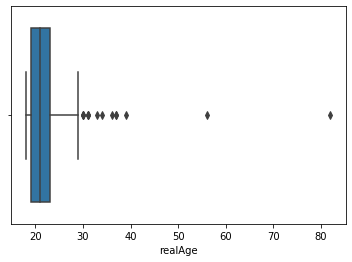

In [13]:
sns.boxplot(test_df['realAge'])

In [14]:
file_singapore.apply(lambda x: x.replace('�', '')).head(20)

,educationInfoForAgeGroupEstimation,workInfoForAgeGroupEstimation,gender,realAge,ageGroup,relationship,educationLevel,occupation,income
0,NaN,NaN,female,NaN,NaN,NaN,NaN,NaN,NaN
1,Bukit Batok Secondary School ITE College West ...,NaN,female,NaN,NaN,NaN,college,NaN,NaN
2,"St Patrick&#039;s School, Singapore Class of 2...",NaN,male,NaN,AGE10_20,single,college,NaN,NaN
3,NaN,NaN,female,NaN,NaN,NaN,NaN,NaN,$$
4,NaN,PT. Duta Marga Lestarindo September 2013 to pr...,female,NaN,NaN,NaN,NaN,archetecture and engineering,NaN
5,Alok Study Group Bandung SMAK TRIMULIA Bandung...,NaN,male,27.0,AGE20_30,single,NaN,NaN,NaN
6,NaN,NaN,female,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,female,NaN,NaN,NaN,NaN,NaN,$
8,NaN,NaN,female,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,female,NaN,NaN,NaN,NaN,NaN,NaN


### Data Cleaning

In [0]:
# Custom Dictionaries
gender_dict = {'male' : 0, 'female' : 1}
reverse_gender_dict = {v:k for k, v in gender_dict.items()}
age_group_dict = {'UNKNOWN': 0, 'AGE10_20': 1, 'AGE20_30': 2, 'AGE30_40': 3, 'AGE40_50': 4, 'AGE50_INF': 5}
reverse_age_group_dict = {v:k for k, v in age_group_dict.items()}
city_dict = {'London': 1, 'New York': 2, 'Singapore': 3}
reverse_city_dict = { v:k for k, v in city_dict.items() }


In [32]:
class PreProcessor:
    """
    Takes a raw DataFrame as input and returns a cleaned and processor
    """
    def __init__(self, nan_drop_threshold=5, train=True, gender_dict=gender_dict, age_group_dict=age_group_dict,
                 city_dict=city_dict):
        self.nan_drop_threshold = nan_drop_threshold
        self.train = train
        self.gender_dict = gender_dict
        self.age_group_dict = age_group_dict
        self.city_dict = city_dict

    def clean(self, dataframe):
        """
        The Clean method will clean the dataframe 
        Operations Performed:
        * Remove the Rows with more than 5 nan's if Train set
        * Replace Gender to numeric values

        Parameters:
        dataframe: Pandas DataFrame

        Output:
        dataframe: Pandas DataFrame
        """

        # Remove Rows with more than 5 nan's
        if train:
            dataframe.dropna(thresh=5, axis=0, inplace=True)

        dataframe['gender'].replace(self.gender_dict, inplace=True)
        
        # Quantize known and Unkown age groups
        dataframe['ageGroup'].fillna('UNKNOWN')
        dataframe['ageGroup'].replace(self.age_group_dict)

        

        


array([nan])

�
